## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

## Downloading Dataset

In [3]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("pavansanagapati/ad-displayclick-data-on-taobaocom")

# print("Path to dataset files:", path)

## Working with Dataset

In [2]:
raw_sample = pd.read_csv("/kaggle/input/ad-displayclick-data-on-taobaocom/raw_sample.csv")
ad_feature = pd.read_csv("/kaggle/input/ad-displayclick-data-on-taobaocom/ad_feature.csv")
user_profile = pd.read_csv("/kaggle/input/ad-displayclick-data-on-taobaocom/user_profile.csv")

#### Data details

In [6]:
print("🔍 Raw Sample Dataset Info:")
print(raw_sample.info())
print('--------------------------')
print("\n🔍 Ad Feature Dataset Info:")
print(ad_feature.info())
print('--------------------------')
print("\n🔍 User Profile Dataset Info:")
print(user_profile.info())

🔍 Raw Sample Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26557961 entries, 0 to 26557960
Data columns (total 6 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   user        int64 
 1   time_stamp  int64 
 2   adgroup_id  int64 
 3   pid         object
 4   nonclk      int64 
 5   clk         int64 
dtypes: int64(5), object(1)
memory usage: 1.2+ GB
None
--------------------------

🔍 Ad Feature Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846811 entries, 0 to 846810
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   adgroup_id   846811 non-null  int64  
 1   cate_id      846811 non-null  int64  
 2   campaign_id  846811 non-null  int64  
 3   customer     846811 non-null  int64  
 4   brand        600481 non-null  float64
 5   price        846811 non-null  float64
dtypes: float64(2), int64(4)
memory usage: 38.8 MB
None
--------------------------

🔍 User Profile Data

In [6]:
print("\n📊 Raw Sample Preview:")
print(raw_sample.head())
print('--------------------------')
print("\n📊 Ad Feature Preview:")
print(ad_feature.head())
print('--------------------------')
print("\n📊 User Profile Preview:")
print(user_profile.head())


📊 Raw Sample Preview:
     user  time_stamp  adgroup_id          pid  nonclk  clk
0  581738  1494137644           1  430548_1007       1    0
1  449818  1494638778           3  430548_1007       1    0
2  914836  1494650879           4  430548_1007       1    0
3  914836  1494651029           5  430548_1007       1    0
4  399907  1494302958           8  430548_1007       1    0
--------------------------

📊 Ad Feature Preview:
   adgroup_id  cate_id  campaign_id  customer     brand   price
0       63133     6406        83237         1   95471.0  170.00
1      313401     6406        83237         1   87331.0  199.00
2      248909      392        83237         1   32233.0   38.00
3      208458      392        83237         1  174374.0  139.00
4      110847     7211       135256         2  145952.0   32.99
--------------------------

📊 User Profile Preview:
   userid  cms_segid  cms_group_id  final_gender_code  age_level  \
0     234          0             5                  2          

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [3]:
print("\n🚨 Missing Values in Raw Sample:")
print(raw_sample.isnull().sum())
print('--------------------------')
print("\n🚨 Missing Values in Ad Feature:")
print(ad_feature.isnull().sum())
print('--------------------------')
print("\n🚨 Missing Values in User Profile:")
print(user_profile.isnull().sum())


🚨 Missing Values in Raw Sample:
user          0
time_stamp    0
adgroup_id    0
pid           0
nonclk        0
clk           0
dtype: int64
--------------------------

🚨 Missing Values in Ad Feature:
adgroup_id          0
cate_id             0
campaign_id         0
customer            0
brand          246330
price               0
dtype: int64
--------------------------

🚨 Missing Values in User Profile:
userid                        0
cms_segid                     0
cms_group_id                  0
final_gender_code             0
age_level                     0
pvalue_level             575917
shopping_level                0
occupation                    0
new_user_class_level     344920
dtype: int64


#### Handling missing values

In [3]:
# Ensure column names have no leading/trailing spaces
user_profile.columns = user_profile.columns.str.strip()
ad_feature.columns = ad_feature.columns.str.strip()

# Fill missing values in 'brand' with -1 to indicate unknown brands
ad_feature.loc[:, 'brand'] = ad_feature['brand'].fillna(-1)

# Fill 'pvalue_level' with mode (most frequent value)
pvalue_mode = user_profile['pvalue_level'].mode()[0]
user_profile.loc[:, 'pvalue_level'] = user_profile['pvalue_level'].fillna(pvalue_mode)

# Ensure 'new_user_class_level' exists before modifying
if 'new_user_class_level' in user_profile.columns:
    new_user_mode = user_profile['new_user_class_level'].mode()[0]
    user_profile.loc[:, 'new_user_class_level'] = user_profile['new_user_class_level'].fillna(new_user_mode)
else:
    print("⚠️ Warning: 'new_user_class_level' column not found. Check dataset headers.")

# Verify if missing values are handled
print("\n🚀 Missing Values After Handling:")
print(ad_feature.isnull().sum())
print(user_profile.isnull().sum())


🚀 Missing Values After Handling:
adgroup_id     0
cate_id        0
campaign_id    0
customer       0
brand          0
price          0
dtype: int64
userid                  0
cms_segid               0
cms_group_id            0
final_gender_code       0
age_level               0
pvalue_level            0
shopping_level          0
occupation              0
new_user_class_level    0
dtype: int64


#### gathering more details

In [9]:
print("\n🛠 Column Names in raw_sample:")
print(raw_sample.columns)

print("\n🛠 Column Names in user_profile:")
print(user_profile.columns)

print("\n🛠 Column Names in ad_feature:")
print(ad_feature.columns)


🛠 Column Names in raw_sample:
Index(['user', 'time_stamp', 'adgroup_id', 'pid', 'nonclk', 'clk'], dtype='object')

🛠 Column Names in user_profile:
Index(['userid', 'cms_segid', 'cms_group_id', 'final_gender_code', 'age_level',
       'pvalue_level', 'shopping_level', 'occupation', 'new_user_class_level'],
      dtype='object')

🛠 Column Names in ad_feature:
Index(['adgroup_id', 'cate_id', 'campaign_id', 'customer', 'brand', 'price'], dtype='object')


In [10]:
# Check if 'user' in raw_sample is the same as 'userid' in user_profile
if 'user' in raw_sample.columns and 'userid' in user_profile.columns:
    print("✅ 'user' and 'userid' match in naming.")

# Check for duplicates in raw_sample
print("\n🔍 Duplicate Rows in raw_sample:", raw_sample.duplicated().sum())

# Check for duplicates in ad_feature
print("\n🔍 Duplicate Rows in ad_feature:", ad_feature.duplicated().sum())

# Check for duplicates in user_profile
print("\n🔍 Duplicate Rows in user_profile:", user_profile.duplicated().sum())

# Check if all 'adgroup_id' in raw_sample exist in ad_feature
missing_ads = raw_sample[~raw_sample['adgroup_id'].isin(ad_feature['adgroup_id'])]
print("\n🚨 Ads in raw_sample not found in ad_feature:", len(missing_ads))

# Check if all 'user' in raw_sample exist in user_profile
missing_users = raw_sample[~raw_sample['user'].isin(user_profile['userid'])]
print("\n🚨 Users in raw_sample not found in user_profile:", len(missing_users))


✅ 'user' and 'userid' match in naming.

🔍 Duplicate Rows in raw_sample: 0

🔍 Duplicate Rows in ad_feature: 0

🔍 Duplicate Rows in user_profile: 0

🚨 Ads in raw_sample not found in ad_feature: 0

🚨 Users in raw_sample not found in user_profile: 1528526


#### Merging All Data

In [5]:
import warnings
warnings.filterwarnings("ignore")  # Suppress all warnings

In [4]:
import numpy as np

# Merge raw_sample with user_profile (left join to keep all interactions)
merged_data = raw_sample.merge(user_profile, left_on='user', right_on='userid', how='left')

# Fill missing user demographic information with default values
merged_data['cms_segid'].fillna(-1, inplace=True)  # Unknown segment
merged_data['cms_group_id'].fillna(-1, inplace=True)  # Unknown group
merged_data['final_gender_code'].fillna(0, inplace=True)  # 0 = Unknown
merged_data['age_level'].fillna(0, inplace=True)  # 0 = Unknown age
merged_data['pvalue_level'].fillna(merged_data['pvalue_level'].median(), inplace=True)  # Median consumption level
merged_data['shopping_level'].fillna(1, inplace=True)  # Assume minimum shopping level
merged_data['occupation'].fillna(0, inplace=True)  # Assume non-student
merged_data['new_user_class_level'].fillna(merged_data['new_user_class_level'].median(), inplace=True)  # Median city level

# Merge with ad_feature
merged_data = merged_data.merge(ad_feature, on='adgroup_id', how='left')

# Drop duplicate 'userid' column
merged_data.drop(columns=['userid'], inplace=True)

# Display the merged dataset info
print("\n✅ Merged Dataset Info After Handling Missing Users:")
print(merged_data.info())

merged_data

<ipython-input-4-9eb6afef4e5e>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['cms_segid'].fillna(-1, inplace=True)  # Unknown segment
<ipython-input-4-9eb6afef4e5e>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac


✅ Merged Dataset Info After Handling Missing Users:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26557961 entries, 0 to 26557960
Data columns (total 19 columns):
 #   Column                Dtype  
---  ------                -----  
 0   user                  int64  
 1   time_stamp            int64  
 2   adgroup_id            int64  
 3   pid                   object 
 4   nonclk                int64  
 5   clk                   int64  
 6   cms_segid             float64
 7   cms_group_id          float64
 8   final_gender_code     float64
 9   age_level             float64
 10  pvalue_level          float64
 11  shopping_level        float64
 12  occupation            float64
 13  new_user_class_level  float64
 14  cate_id               int64  
 15  campaign_id           int64  
 16  customer              int64  
 17  brand                 float64
 18  price                 float64
dtypes: float64(10), int64(8), object(1)
memory usage: 3.8+ GB
None


,user,time_stamp,adgroup_id,pid,nonclk,clk,cms_segid,cms_group_id,final_gender_code,age_level,pvalue_level,shopping_level,occupation,new_user_class_level,cate_id,campaign_id,customer,brand,price
0,581738,1494137644,1,430548_1007,1,0,0.0,8.0,1.0,2.0,2.0,3.0,0.0,2.0,9025,108570,1337,20169.0,17.0
1,449818,1494638778,3,430548_1007,1,0,-1.0,-1.0,0.0,0.0,2.0,1.0,0.0,2.0,5998,224368,30507,-1.0,1.0
2,914836,1494650879,4,430548_1007,1,0,0.0,5.0,2.0,5.0,2.0,3.0,0.0,2.0,7958,385883,39662,216840.0,85.0
3,914836,1494651029,5,430548_1007,1,0,0.0,5.0,2.0,5.0,2.0,3.0,0.0,2.0,7958,385883,39662,216840.0,60.0
4,399907,1494302958,8,430548_1007,1,0,0.0,5.0,2.0,5.0,2.0,3.0,0.0,2.0,1626,388290,42349,241359.0,63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26557956,6834,1494139949,846808,430548_1007,1,0,0.0,2.0,2.0,2.0,2.0,3.0,0.0,2.0,5357,390839,45037,446695.0,58.0
26557957,16815,1494328475,846808,430548_1007,1,0,0.0,11.0,1.0,5.0,2.0,3.0,0.0,4.0,5357,390839,45037,446695.0,58.0
26557958,736609,1494597871,846809,430548_1007,1,0,0.0,11.0,1.0,5.0,2.0,3.0,0.0,2.0,494,395873,50320,288222.0,7.2
26557959,735781,1494684550,846809,430539_1007,1,0,81.0,10.0,1.0,4.0,2.0,3.0,0.0,4.0,494,395873,50320,288222.0,7.2


In [5]:
if "clk" in merged_data.columns:
    print("✅ Found 'clk' column in merged_data.")

✅ Found 'clk' column in merged_data.


In [9]:
# Import necessary libraries
import pandas as pd

# Display basic statistics
print("\n📊 Basic Statistics:")
print(merged_data.describe())

# Check the number of unique values in categorical columns
print("\n🔢 Unique Value Counts:")
print(merged_data.nunique())

# Calculate click-through rate (CTR)
total_clicks = merged_data['clk'].sum()
total_impressions = merged_data.shape[0]
ctr = total_clicks / total_impressions * 100  # Percentage

print(f"\n🎯 Click-Through Rate (CTR): {ctr:.2f}%")

merged_data.describe()



📊 Basic Statistics:
               user    time_stamp    adgroup_id        nonclk           clk  \
count  2.655796e+07  2.655796e+07  2.655796e+07  2.655796e+07  2.655796e+07   
mean   5.682055e+05  1.494355e+09  5.130175e+05  9.485632e-01  5.143678e-02   
std    3.297502e+05  1.987553e+05  2.183782e+05  2.208869e-01  2.208869e-01   
min    1.000000e+00  1.494000e+09  1.000000e+00  0.000000e+00  0.000000e+00   
25%    2.829190e+05  1.494171e+09  3.606780e+05  1.000000e+00  0.000000e+00   
50%    5.649520e+05  1.494345e+09  5.638330e+05  1.000000e+00  0.000000e+00   
75%    8.521910e+05  1.494516e+09  6.867050e+05  1.000000e+00  0.000000e+00   
max    1.141729e+06  1.494691e+09  8.468110e+05  1.000000e+00  1.000000e+00   

          cms_segid  cms_group_id  final_gender_code     age_level  \
count  2.655796e+07  2.655796e+07       2.655796e+07  2.655796e+07   
mean   1.391799e+01  4.688014e+00       1.625799e+00  3.191738e+00   
std    2.396473e+01  3.287618e+00       5.910020e-01  1.3

,user,time_stamp,adgroup_id,nonclk,clk,cms_segid,cms_group_id,final_gender_code,age_level,pvalue_level,shopping_level,occupation,new_user_class_level,cate_id,campaign_id,customer,brand,price
count,2.655796e+07,2.655796e+07,2.655796e+07,2.655796e+07,2.655796e+07,2.655796e+07,2.655796e+07,2.655796e+07,2.655796e+07,2.655796e+07,2.655796e+07,2.655796e+07,2.655796e+07,2.655796e+07,2.655796e+07,2.655796e+07,2.655796e+07,2.655796e+07
mean,5.682055e+05,1.494355e+09,5.130175e+05,9.485632e-01,5.143678e-02,1.391799e+01,4.688014e+00,1.625799e+00,3.191738e+00,1.878683e+00,2.702962e+00,5.135741e-02,2.382239e+00,5.304595e+03,2.094651e+05,1.114870e+05,1.541515e+05,7.473391e+02
std,3.297502e+05,1.987553e+05,2.183782e+05,2.208869e-01,2.208869e-01,2.396473e+01,3.287618e+00,5.910020e-01,1.398338e+00,4.172189e-01,6.388760e-01,2.207257e-01,8.105059e-01,2.353807e+03,1.244150e+05,7.453769e+04,1.501117e+05,1.323651e+05
min,1.000000e+00,1.494000e+09,1.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,1.000000e-02
25%,2.829190e+05,1.494171e+09,3.606780e+05,1.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,0.000000e+00,2.000000e+00,4.282000e+03,1.028290e+05,4.452100e+04,-1.000000e+00,8.600000e+01
50%,5.649520e+05,1.494345e+09,5.638330e+05,1.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,2.000000e+00,3.000000e+00,2.000000e+00,3.000000e+00,0.000000e+00,2.000000e+00,5.868000e+03,2.049150e+05,1.056200e+05,1.157600e+05,1.680000e+02
75%,8.521910e+05,1.494516e+09,6.867050e+05,1.000000e+00,0.000000e+00,1.900000e+01,7.000000e+00,2.000000e+00,4.000000e+00,2.000000e+00,3.000000e+00,0.000000e+00,3.000000e+00,6.426000e+03,3.207090e+05,1.700990e+05,2.761100e+05,3.280000e+02
max,1.141729e+06,1.494691e+09,8.468110e+05,1.000000e+00,1.000000e+00,9.600000e+01,1.200000e+01,2.000000e+00,6.000000e+00,3.000000e+00,3.000000e+00,1.000000e+00,4.000000e+00,1.296000e+04,4.234360e+05,2.558750e+05,4.614970e+05,1.000000e+08


## Visualizations

#### ctr distribution

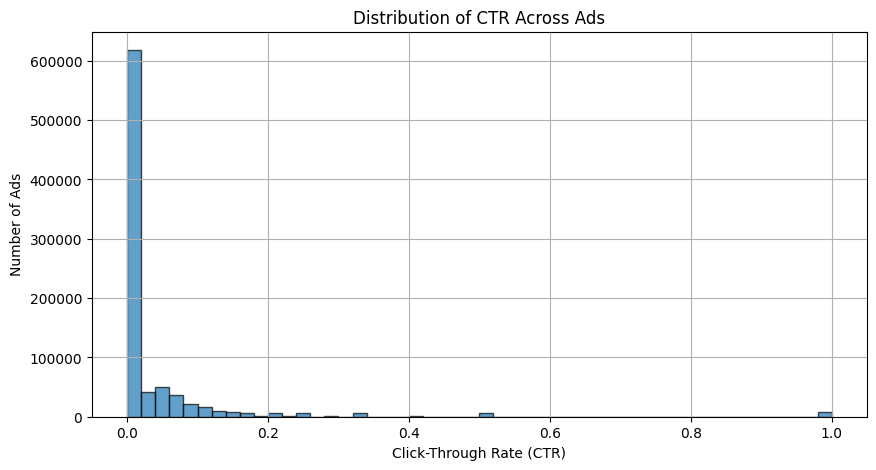

In [14]:
import matplotlib.pyplot as plt

# Aggregate CTR by ad
ctr_data = merged_data.groupby("adgroup_id")["clk"].mean()

# Plot CTR distribution
plt.figure(figsize=(10, 5))
plt.hist(ctr_data, bins=50, edgecolor="black", alpha=0.7)
plt.xlabel("Click-Through Rate (CTR)")
plt.ylabel("Number of Ads")
plt.title("Distribution of CTR Across Ads")
plt.grid(True)
plt.show()

#### Click-Through Rate (CTR) vs. Ad Price

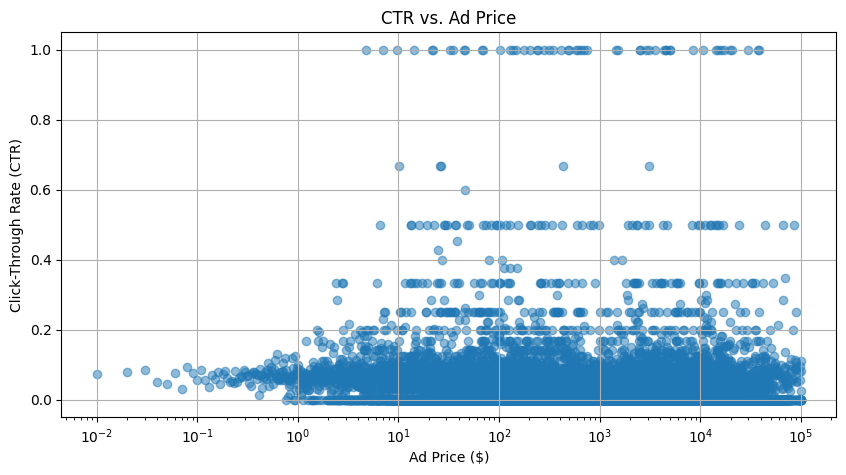

In [15]:
import matplotlib.pyplot as plt

# Aggregate CTR by price
ctr_price_data = merged_data.groupby("price")["clk"].mean().reset_index()

# Filter out extreme outliers (e.g., price > 100,000)
ctr_price_data = ctr_price_data[ctr_price_data["price"] < 100000]

# Plot CTR vs. Price
plt.figure(figsize=(10, 5))
plt.scatter(ctr_price_data["price"], ctr_price_data["clk"], alpha=0.5)
plt.xlabel("Ad Price ($)")
plt.ylabel("Click-Through Rate (CTR)")
plt.title("CTR vs. Ad Price")
plt.xscale("log")  # Log scale for better visibility
plt.grid(True)
plt.show()

#### CTR by Category (Bar Chart)

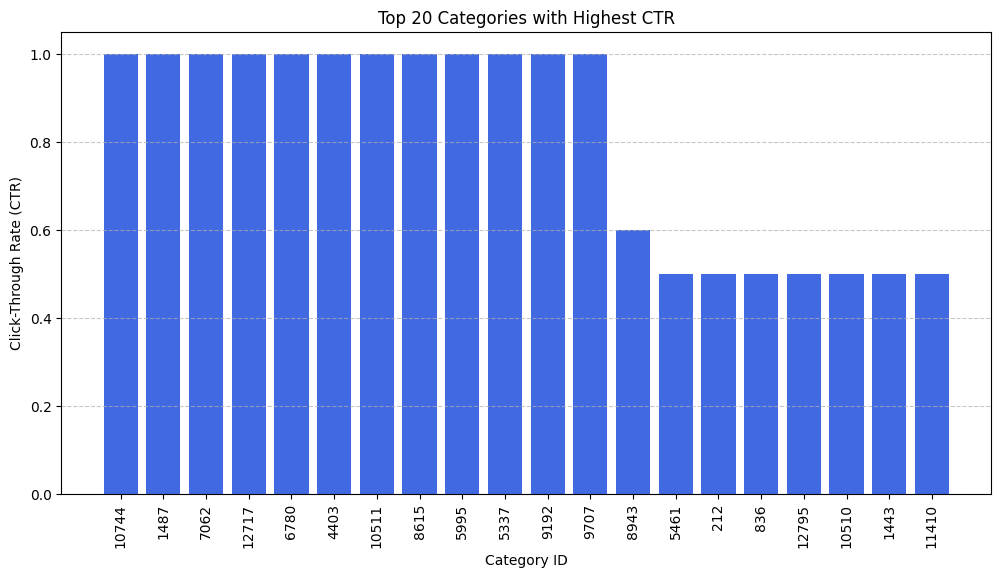

In [16]:
import matplotlib.pyplot as plt

# Aggregate CTR by category
ctr_category = merged_data.groupby("cate_id")["clk"].mean().reset_index()

# Sort categories by CTR
ctr_category = ctr_category.sort_values(by="clk", ascending=False).head(20)  # Top 20 categories

# Plot CTR by category
plt.figure(figsize=(12, 6))
plt.bar(ctr_category["cate_id"].astype(str), ctr_category["clk"], color="royalblue")
plt.xlabel("Category ID")
plt.ylabel("Click-Through Rate (CTR)")
plt.title("Top 20 Categories with Highest CTR")
plt.xticks(rotation=90)  # Rotate labels for readability
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

#### CTR by Gender (Bar Chart)

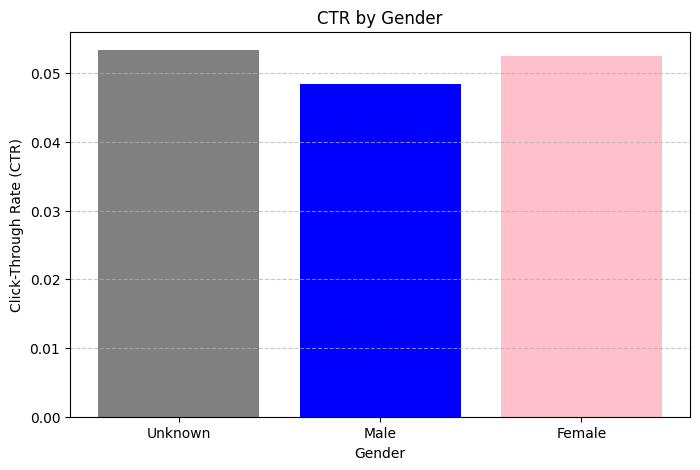

In [17]:
import matplotlib.pyplot as plt

# Aggregate CTR by gender
ctr_gender = merged_data.groupby("final_gender_code")["clk"].mean().reset_index()

# Map gender codes to labels
gender_labels = {0: "Unknown", 1: "Male", 2: "Female"}
ctr_gender["final_gender_code"] = ctr_gender["final_gender_code"].map(gender_labels)

# Plot CTR by gender
plt.figure(figsize=(8, 5))
plt.bar(ctr_gender["final_gender_code"], ctr_gender["clk"], color=["gray", "blue", "pink"])
plt.xlabel("Gender")
plt.ylabel("Click-Through Rate (CTR)")
plt.title("CTR by Gender")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

#### Click-Through Rate (CTR) by Age Group

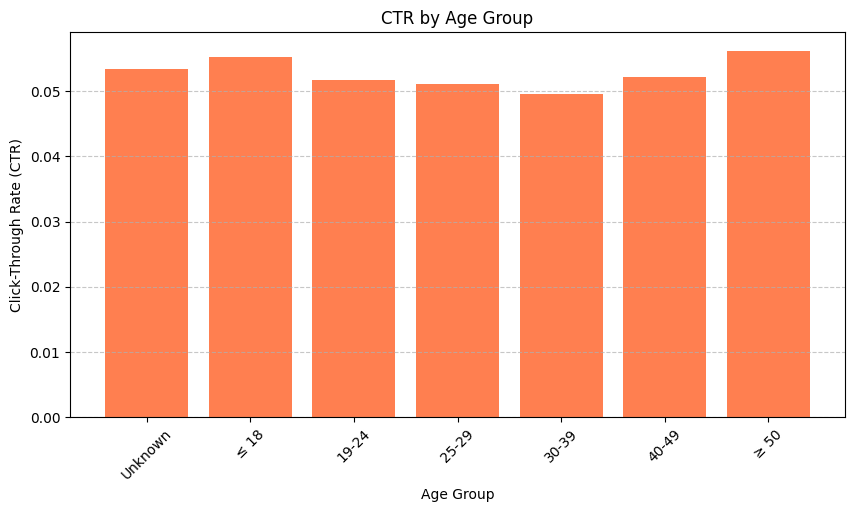

In [18]:
import matplotlib.pyplot as plt

# Aggregate CTR by age level
ctr_age = merged_data.groupby("age_level")["clk"].mean().reset_index()

# Define age labels
age_labels = {
    0: "Unknown",
    1: "≤ 18",
    2: "19-24",
    3: "25-29",
    4: "30-39",
    5: "40-49",
    6: "≥ 50"
}
ctr_age["age_level"] = ctr_age["age_level"].map(age_labels)

# Plot CTR by age level
plt.figure(figsize=(10, 5))
plt.bar(ctr_age["age_level"], ctr_age["clk"], color="coral")
plt.xlabel("Age Group")
plt.ylabel("Click-Through Rate (CTR)")
plt.title("CTR by Age Group")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

#### Click-Through Rate (CTR) by Shopping Behavior

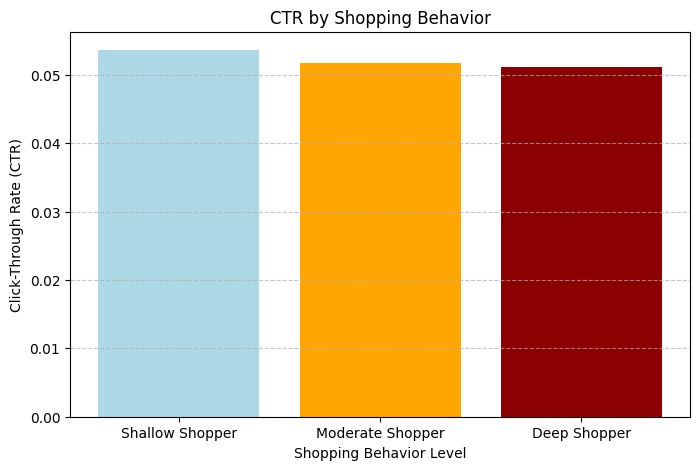

In [19]:
import matplotlib.pyplot as plt

# Aggregate CTR by shopping level
ctr_shopping = merged_data.groupby("shopping_level")["clk"].mean().reset_index()

# Define shopping level labels
shopping_labels = {
    1: "Shallow Shopper",
    2: "Moderate Shopper",
    3: "Deep Shopper"
}
ctr_shopping["shopping_level"] = ctr_shopping["shopping_level"].map(shopping_labels)

# Plot CTR by shopping level
plt.figure(figsize=(8, 5))
plt.bar(ctr_shopping["shopping_level"], ctr_shopping["clk"], color=["lightblue", "orange", "darkred"])
plt.xlabel("Shopping Behavior Level")
plt.ylabel("Click-Through Rate (CTR)")
plt.title("CTR by Shopping Behavior")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

#### Click-Through Rate (CTR) Over Time (Hourly Trends)

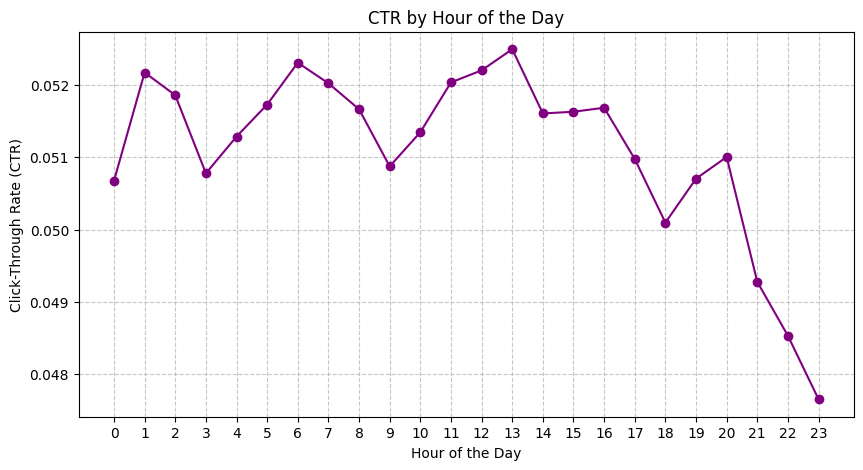

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert timestamp to datetime format
merged_data["time_stamp"] = pd.to_datetime(merged_data["time_stamp"], unit="s")

# Extract hour from timestamp
merged_data["hour"] = merged_data["time_stamp"].dt.hour

# Aggregate CTR by hour
ctr_hour = merged_data.groupby("hour")["clk"].mean().reset_index()

# Plot CTR by hour
plt.figure(figsize=(10, 5))
plt.plot(ctr_hour["hour"], ctr_hour["clk"], marker="o", linestyle="-", color="purple")
plt.xlabel("Hour of the Day")
plt.ylabel("Click-Through Rate (CTR)")
plt.title("CTR by Hour of the Day")
plt.xticks(range(0, 24))
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

#### Click-Through Rate (CTR) by City Level (Urban vs. Rural Users)

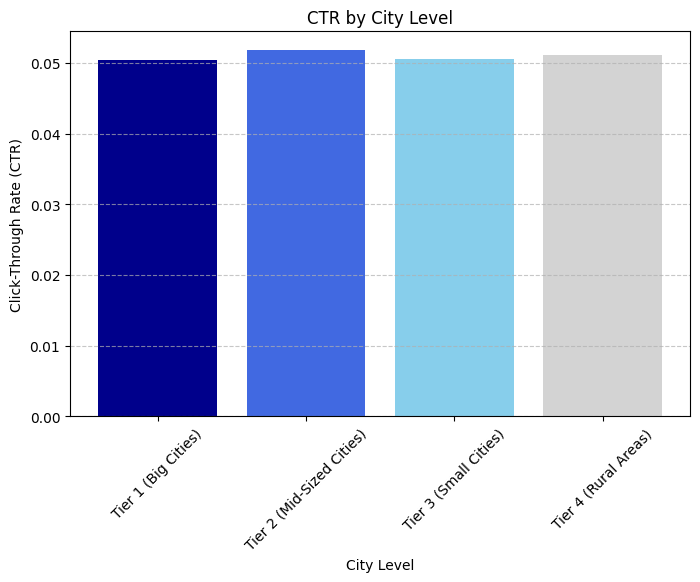

In [21]:
import matplotlib.pyplot as plt

# Aggregate CTR by city level
ctr_city = merged_data.groupby("new_user_class_level")["clk"].mean().reset_index()

# Define city level labels
city_labels = {
    1: "Tier 1 (Big Cities)",
    2: "Tier 2 (Mid-Sized Cities)",
    3: "Tier 3 (Small Cities)",
    4: "Tier 4 (Rural Areas)"
}
ctr_city["new_user_class_level"] = ctr_city["new_user_class_level"].map(city_labels)

# Plot CTR by city level
plt.figure(figsize=(8, 5))
plt.bar(ctr_city["new_user_class_level"], ctr_city["clk"], color=["darkblue", "royalblue", "skyblue", "lightgray"])
plt.xlabel("City Level")
plt.ylabel("Click-Through Rate (CTR)")
plt.title("CTR by City Level")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=45)
plt.show()

#### Most Clicked Brands

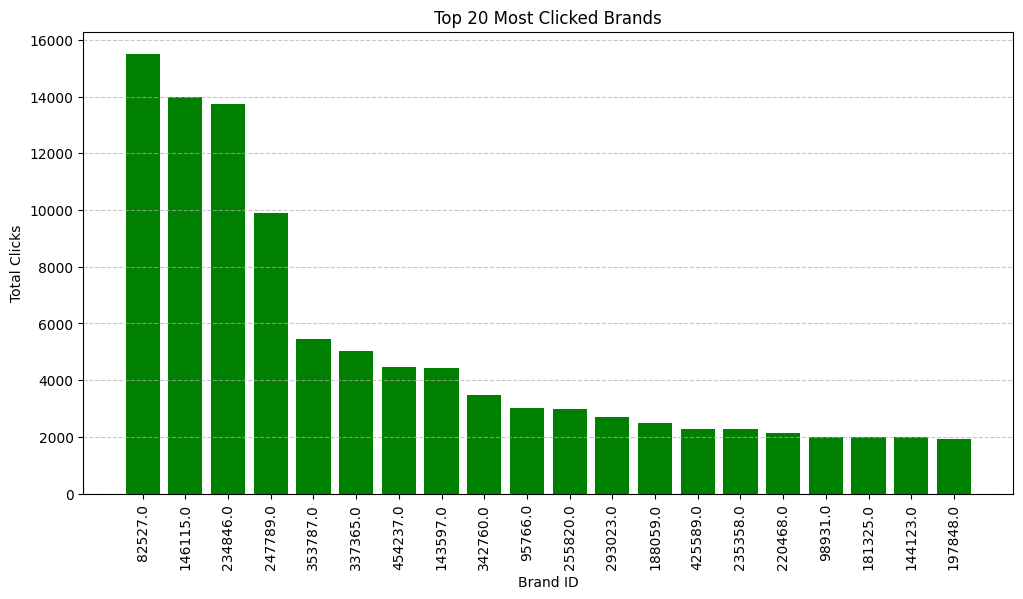

In [22]:
import matplotlib.pyplot as plt

# Aggregate total clicks per brand
clicked_brands = merged_data.groupby("brand")["clk"].sum().reset_index()

# Remove unknown brands (-1)
clicked_brands = clicked_brands[clicked_brands["brand"] != -1]

# Sort and get the top 20 brands
clicked_brands = clicked_brands.sort_values(by="clk", ascending=False).head(20)

# Plot the top 20 clicked brands
plt.figure(figsize=(12, 6))
plt.bar(clicked_brands["brand"].astype(str), clicked_brands["clk"], color="green")
plt.xlabel("Brand ID")
plt.ylabel("Total Clicks")
plt.title("Top 20 Most Clicked Brands")
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## Feature Engineering

### User-based

In [5]:
# Calculate total clicks per user
user_clicks = merged_data.groupby("user")["clk"].sum().rename("user_total_clicks")

# Calculate total impressions per user
user_impressions = merged_data.groupby("user")["clk"].count().rename("user_total_impressions")

# Calculate user CTR (Click-Through Rate)
user_ctr = (user_clicks / user_impressions).fillna(0).rename("user_ctr")

# Identify the most clicked category per user
user_most_clicked_category = (
    merged_data[merged_data["clk"] == 1].groupby("user")["cate_id"]
    .agg(lambda x: x.value_counts().idxmax())
    .rename("user_most_clicked_category")
)

# Identify the most clicked brand per user
user_most_clicked_brand = (
    merged_data[merged_data["clk"] == 1].groupby("user")["brand"]
    .agg(lambda x: x.value_counts().idxmax())
    .rename("user_most_clicked_brand")
)

# Merge user features into the main dataset
merged_data = merged_data.merge(user_clicks, on="user", how="left")
merged_data = merged_data.merge(user_impressions, on="user", how="left")
merged_data = merged_data.merge(user_ctr, on="user", how="left")
merged_data = merged_data.merge(user_most_clicked_category, on="user", how="left")
merged_data = merged_data.merge(user_most_clicked_brand, on="user", how="left")

# Fill missing values with defaults
merged_data["user_total_clicks"].fillna(0, inplace=True)
merged_data["user_total_impressions"].fillna(0, inplace=True)
merged_data["user_ctr"].fillna(0, inplace=True)
merged_data["user_most_clicked_category"].fillna(-1, inplace=True)
merged_data["user_most_clicked_brand"].fillna(-1, inplace=True)

<ipython-input-5-e23b0ecb965c>:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data["user_total_clicks"].fillna(0, inplace=True)
<ipython-input-5-e23b0ecb965c>:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

### Ad-based

In [6]:
# Calculate total clicks per ad
ad_clicks = merged_data.groupby("adgroup_id")["clk"].sum().rename("ad_total_clicks")

# Calculate total impressions per ad
ad_impressions = merged_data.groupby("adgroup_id")["clk"].count().rename("ad_total_impressions")

# Calculate ad CTR
ad_ctr = (ad_clicks / ad_impressions).fillna(0).rename("ad_ctr")

# Calculate brand CTR (how well a brand performs overall)
brand_ctr = (
    merged_data.groupby("brand")["clk"].mean().fillna(0).rename("brand_ctr")
)

# Define price buckets
def categorize_price(price):
    if price < 50:
        return "cheap"
    elif price < 200:
        return "mid-range"
    else:
        return "expensive"

merged_data["price_bucket"] = merged_data["price"].apply(categorize_price)

# Merge ad features
merged_data = merged_data.merge(ad_clicks, on="adgroup_id", how="left")
merged_data = merged_data.merge(ad_impressions, on="adgroup_id", how="left")
merged_data = merged_data.merge(ad_ctr, on="adgroup_id", how="left")
merged_data = merged_data.merge(brand_ctr, on="brand", how="left")

# Fill missing values
merged_data["ad_total_clicks"].fillna(0, inplace=True)
merged_data["ad_total_impressions"].fillna(0, inplace=True)
merged_data["ad_ctr"].fillna(0, inplace=True)
merged_data["brand_ctr"].fillna(0, inplace=True)

<ipython-input-6-746ee534de21>:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data["ad_total_clicks"].fillna(0, inplace=True)
<ipython-input-6-746ee534de21>:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

### Interaction-Based Features

In [7]:
# Calculate user-brand interaction
user_brand_interaction = (
    merged_data.groupby(["user", "brand"])["clk"].sum().rename("user_brand_interaction")
)

# Calculate user-category interaction
user_category_interaction = (
    merged_data.groupby(["user", "cate_id"])["clk"].sum().rename("user_category_interaction")
)

# Merge into the main dataset
merged_data = merged_data.merge(user_brand_interaction, on=["user", "brand"], how="left")
merged_data = merged_data.merge(user_category_interaction, on=["user", "cate_id"], how="left")

# Fill missing values
merged_data["user_brand_interaction"].fillna(0, inplace=True)
merged_data["user_category_interaction"].fillna(0, inplace=True)

<ipython-input-7-5f1fb5702cf3>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data["user_brand_interaction"].fillna(0, inplace=True)
<ipython-input-7-5f1fb5702cf3>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

### Time-Based Features

In [8]:
import pandas as pd

# Convert timestamp to datetime
merged_data["time_stamp"] = pd.to_datetime(merged_data["time_stamp"], unit="s")

# Extract hour and day of the week
merged_data["hour_of_day"] = merged_data["time_stamp"].dt.hour
merged_data["day_of_week"] = merged_data["time_stamp"].dt.dayofweek


In [ ]:
import pandas as pd

# Display first few rows to check new features
print("\n🔍 Preview of Engineered Features:")
print(merged_data.head())

# Display summary statistics for newly engineered features
engineered_feature_cols = [
    "user_total_clicks", "user_total_impressions", "user_ctr",
    "user_most_clicked_category", "user_most_clicked_brand",
    "ad_total_clicks", "ad_total_impressions", "ad_ctr",
    "brand_ctr", "price_bucket", "user_brand_interaction",
    "user_category_interaction", "hour_of_day", "day_of_week"
]

print("\n📊 Summary Statistics for Engineered Features:")
print(merged_data[engineered_feature_cols].describe())

# Show unique values in categorical features (to check if encoding is needed)
print("\n🔢 Unique Value Counts in Categorical Features:")
print(merged_data[["price_bucket", "user_most_clicked_category", "user_most_clicked_brand"]].nunique())

# Show the first few rows of the dataset for manual inspection
merged_data.sample(10)


In [9]:
engineered_feature_cols = [
    "user_total_clicks", "user_total_impressions", "user_ctr",
    "user_most_clicked_category", "user_most_clicked_brand",
    "ad_total_clicks", "ad_total_impressions", "ad_ctr",
    "brand_ctr", "price_bucket", "user_brand_interaction",
    "user_category_interaction", "hour_of_day", "day_of_week"
]
engineered_features = merged_data[engineered_feature_cols]
engineered_features["clk"] = merged_data["clk"].values
engineered_features.to_csv("/kaggle/working/engineered_featured.csv", index=False)
print("✅ Engineered dataset saved successfully!")

<ipython-input-9-4864b8d7dbe8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  engineered_features["clk"] = merged_data["clk"].values


✅ Engineered dataset saved successfully!


## Splitting Data

## Baseline Models

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Select features (excluding IDs & raw timestamps)
features = [
    "user_total_clicks", "user_total_impressions", "user_ctr",
    "user_most_clicked_category", "user_most_clicked_brand",
    "ad_total_clicks", "ad_total_impressions", "ad_ctr",
    "brand_ctr", "user_brand_interaction", "user_category_interaction",
    "hour_of_day", "day_of_week", "price_bucket"
]

# Encode categorical features
label_encoders = {}
for cat_feature in ["price_bucket", "user_most_clicked_category", "user_most_clicked_brand"]:
    le = LabelEncoder()
    merged_data[cat_feature] = le.fit_transform(merged_data[cat_feature].astype(str))
    label_encoders[cat_feature] = le

# Define target variable (click = 1, no click = 0)
X = merged_data[features]
y = merged_data["clk"]

# Split data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"✅ Data prepared! Training set: {X_train.shape}, Test set: {X_test.shape}")

✅ Data prepared! Training set: (21246368, 14), Test set: (5311593, 14)


### XGBoost

In [29]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, recall_score, 
    f1_score, log_loss, classification_report
)

In [30]:
import xgboost as xgb

# Train XGBoost with GPU acceleration
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    use_label_encoder=False,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="gpu_hist"  # Enables GPU acceleration
)


In [31]:
xgb_model.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.8,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'auc',
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 6,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.8,
 'tree_method': 'gpu_hist',
 'validate_parameters': None,
 'verbosity': None,
 'use_label_encoder': False}

In [32]:
xgb_model.fit(X_train, y_train)

print("✅ XGBoost Training Completed Using GPU!")

✅ XGBoost Training Completed Using GPU!


In [33]:
# Predict on test set
y_pred_xgb = xgb_model.predict(X_test)
y_pred_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Compute evaluation metrics
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_pred_prob_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
log_loss_xgb = log_loss(y_test, y_pred_prob_xgb)

# Display results
print(f"\n📊 XGBoost Performance:")
print(f"✔ Accuracy: {accuracy_xgb:.4f}")
print(f"✔ AUC Score: {auc_xgb:.4f}")
print(f"✔ Precision: {precision_xgb:.4f}")
print(f"✔ Recall: {recall_xgb:.4f}")
print(f"✔ F1-Score: {f1_xgb:.4f}")
print(f"✔ Log Loss: {log_loss_xgb:.4f}")

# Display detailed classification report
print("\n🔍 Classification Report for XGBoost:")
print(classification_report(y_test, y_pred_xgb))



📊 XGBoost Performance:
✔ Accuracy: 0.9623
✔ AUC Score: 0.9754
✔ Precision: 0.6813
✔ Recall: 0.5028
✔ F1-Score: 0.5786
✔ Log Loss: 0.0820

🔍 Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98   5038382
           1       0.68      0.50      0.58    273211

    accuracy                           0.96   5311593
   macro avg       0.83      0.75      0.78   5311593
weighted avg       0.96      0.96      0.96   5311593



## Deep Learning Models

### Deep Interest Network (DIN)

In [6]:
# !pip uninstall -y tensorflow keras deepctr deepctr-torch
!pip install torch==2.1.0
!pip install deepctr-torch==0.2.9

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 104.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 80.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 15.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 3.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 8.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, log_loss, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("/kaggle/working/engineered_featured.csv")
print("✅ Engineered data loaded.")

✅ Engineered data loaded.


In [3]:
# data["clk"] = merged_data["clk"].values
print(data.columns.tolist())

['user_total_clicks', 'user_total_impressions', 'user_ctr', 'user_most_clicked_category', 'user_most_clicked_brand', 'ad_total_clicks', 'ad_total_impressions', 'ad_ctr', 'brand_ctr', 'price_bucket', 'user_brand_interaction', 'user_category_interaction', 'hour_of_day', 'day_of_week', 'clk']


In [4]:
data

,user_total_clicks,user_total_impressions,user_ctr,user_most_clicked_category,user_most_clicked_brand,ad_total_clicks,ad_total_impressions,ad_ctr,brand_ctr,price_bucket,user_brand_interaction,user_category_interaction,hour_of_day,day_of_week,clk
0,13,213,0.061033,9498.0,-1.0,0,1,0.0,0.000000,cheap,0,0,6,6,0
1,0,4,0.000000,-1.0,-1.0,0,1,0.0,0.055155,cheap,0,0,1,5,0
2,1,39,0.025641,7958.0,454237.0,0,1,0.0,0.060606,mid-range,0,1,4,5,0
3,1,39,0.025641,7958.0,454237.0,0,1,0.0,0.060606,mid-range,0,1,4,5,0
4,0,21,0.000000,-1.0,-1.0,0,1,0.0,0.054264,mid-range,0,0,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26557956,8,70,0.114286,6136.0,-1.0,0,2,0.0,0.000000,mid-range,0,1,6,6,0
26557957,0,9,0.000000,-1.0,-1.0,0,2,0.0,0.000000,mid-range,0,0,11,1,0
26557958,5,57,0.087719,1535.0,138520.0,0,2,0.0,0.018519,cheap,0,1,14,4,0
26557959,2,89,0.022472,7185.0,326090.0,0,2,0.0,0.018519,cheap,0,0,14,5,0


In [5]:
# 2. Define categorical and numerical features
cat_features = ["user_most_clicked_category", "user_most_clicked_brand", "price_bucket"]
num_features = [
    "user_total_clicks", "user_total_impressions", "user_ctr",
    "ad_total_clicks", "ad_total_impressions", "ad_ctr",
    "brand_ctr", "user_brand_interaction", "user_category_interaction",
    "hour_of_day", "day_of_week"
]

# 3. Preprocess the data
# First, handle missing values in categorical features (replace -1.0 with a string value for encoding)
for feat in cat_features:
    if feat in data.columns:
        data[feat] = data[feat].fillna("UNKNOWN")
        data[feat] = data[feat].replace(-1.0, "UNKNOWN")

# Handle missing values in numerical features
for feat in num_features:
    if feat in data.columns:
        data[feat] = data[feat].fillna(0)

# Apply label encoding to categorical features
label_encoders = {}
for feat in cat_features:
    if feat in data.columns:
        label_encoders[feat] = LabelEncoder()
        data[feat] = label_encoders[feat].fit_transform(data[feat].astype(str))
        # Get vocabulary size for embedding layers
        label_encoders[feat + "_vocab_size"] = len(label_encoders[feat].classes_)

# Normalize numerical features
scaler = StandardScaler()
data[num_features] = scaler.fit_transform(data[num_features])

# 4. Split the data
X = data.drop("clk", axis=1)
y = data["clk"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")
print(f"Positive class distribution - Train: {y_train.mean():.4f}, Test: {y_test.mean():.4f}")

Training set shape: (21246368, 14), Test set shape: (5311593, 14)
Positive class distribution - Train: 0.0514, Test: 0.0514


In [6]:
# 5. Define the DIN model
def build_din_model(cat_features, cat_vocab_sizes, num_features, embedding_dim=16):
    """
    Build a Deep Interest Network model
    
    Args:
        cat_features: List of categorical feature names
        cat_vocab_sizes: List of vocabulary sizes for each categorical feature
        num_features: List of numerical feature names
        embedding_dim: Dimension of embedding vectors
        
    Returns:
        A compiled Keras model
    """
    # Input layers
    inputs = {}
    
    # Categorical feature inputs
    for feat in cat_features:
        if feat in X_train.columns:
            inputs[feat] = tf.keras.layers.Input(shape=(1,), name=feat)
    
    # Numerical feature inputs
    for feat in num_features:
        if feat in X_train.columns:
            inputs[feat] = tf.keras.layers.Input(shape=(1,), name=feat)
    
    # Embedding layers for categorical features
    embeddings = {}
    for i, feat in enumerate(cat_features):
        if feat in X_train.columns:
            embedding = tf.keras.layers.Embedding(
                input_dim=cat_vocab_sizes[i] + 1,  # +1 for unknown tokens
                output_dim=embedding_dim,
                name=f"{feat}_embedding"
            )(inputs[feat])
            embeddings[feat] = tf.keras.layers.Flatten()(embedding)
    
    # Concatenate all features
    numerical_inputs = [inputs[feat] for feat in num_features if feat in X_train.columns]
    if numerical_inputs:
        numerical_concat = tf.keras.layers.Concatenate()(numerical_inputs)
    else:
        numerical_concat = None
    
    categorical_embeds = list(embeddings.values())
    
    if numerical_concat is not None:
        if categorical_embeds:
            concat_features = tf.keras.layers.Concatenate()([numerical_concat] + categorical_embeds)
        else:
            concat_features = numerical_concat
    else:
        if categorical_embeds:
            concat_features = tf.keras.layers.Concatenate()(categorical_embeds)
        else:
            raise ValueError("No features available")
    
    # Interest extraction layers with attention mechanism
    
    # First, create a feature representation for the ad
    ad_features = tf.keras.layers.Dense(64, activation='relu', name='ad_representation')(concat_features)
    
    # Create a representation for user interests
    user_features = tf.keras.layers.Dense(64, activation='relu', name='user_representation')(concat_features)
    
    # Attention mechanism - this is the core of DIN
    attention_input = tf.keras.layers.Concatenate()([ad_features, user_features])
    attention = tf.keras.layers.Dense(32, activation='relu')(attention_input)
    attention = tf.keras.layers.Dense(16, activation='relu')(attention)
    attention = tf.keras.layers.Dense(1, activation='sigmoid', name='attention_weight')(attention)
    
    # Apply attention
    attended_features = tf.keras.layers.Multiply()([user_features, attention])
    
    # Combine attended user features with ad features
    combined = tf.keras.layers.Concatenate()([attended_features, ad_features])
    
    # DNN layers
    dnn = tf.keras.layers.Dense(128, activation='relu')(combined)
    dnn = tf.keras.layers.BatchNormalization()(dnn)
    dnn = tf.keras.layers.Dropout(0.3)(dnn)
    dnn = tf.keras.layers.Dense(64, activation='relu')(dnn)
    dnn = tf.keras.layers.BatchNormalization()(dnn)
    dnn = tf.keras.layers.Dropout(0.2)(dnn)
    
    # Output layer
    output = tf.keras.layers.Dense(1, activation='sigmoid')(dnn)
    
    # Create model
    model = tf.keras.Model(inputs=list(inputs.values()), outputs=output)
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[
            'accuracy', 
            tf.keras.metrics.AUC(), 
            tf.keras.metrics.Precision(), 
            tf.keras.metrics.Recall()
        ]
    )
    
    return model


In [7]:
# 6. Prepare input data for the model
def prepare_model_inputs(X, cat_features, num_features):
    """Prepare the input data in the format required by the model"""
    model_inputs = {}
    for feat in cat_features:
        if feat in X.columns:
            model_inputs[feat] = X[feat].values.reshape(-1, 1)
    for feat in num_features:
        if feat in X.columns:
            model_inputs[feat] = X[feat].values.reshape(-1, 1)
    return model_inputs

# Get vocabulary sizes for each categorical feature
cat_vocab_sizes = [label_encoders.get(feat + "_vocab_size", 1) for feat in cat_features if feat in X_train.columns]

# 7. Build and train the model
din_model = build_din_model(
    [feat for feat in cat_features if feat in X_train.columns],
    cat_vocab_sizes,
    [feat for feat in num_features if feat in X_train.columns]
)

# print(din_model.summary())

# Prepare inputs
train_inputs = prepare_model_inputs(X_train, cat_features, num_features)
test_inputs = prepare_model_inputs(X_test, cat_features, num_features)

# Define callbacks for training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_auc',
        patience=3,
        mode='max',
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-5
    )
]

# Train the model
history = din_model.fit(
    train_inputs, y_train,
    validation_data=(test_inputs, y_test),
    epochs=15,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15
82994/82994 ━━━━━━━━━━━━━━━━━━━━ 327s 4ms/step - accuracy: 0.9464 - auc: 0.7594 - loss: 0.1803 - precision: 0.3275 - recall: 0.0210 - val_accuracy: 0.9112 - val_auc: 0.7527 - val_loss: 0.3124 - val_precision: 0.2286 - val_recall: 0.3061 - learning_rate: 0.0010
Epoch 2/15
82994/82994 ━━━━━━━━━━━━━━━━━━━━ 313s 4ms/step - accuracy: 0.9522 - auc: 0.9344 - loss: 0.1196 - precision: 0.6220 - recall: 0.1806 - val_accuracy: 0.9457 - val_auc: 0.8020 - val_loss: 0.1871 - val_precision: 0.3992 - val_recall: 0.1093 - learning_rate: 0.0010
Epoch 3/15
82994/82994 ━━━━━━━━━━━━━━━━━━━━ 311s 4ms/step - accuracy: 0.9530 - auc: 0.9475 - loss: 0.1106 - precision: 0.6213 - recall: 0.2188 - val_accuracy: 0.5546 - val_auc: 0.6171 - val_loss: 0.5459 - val_precision: 0.0516 - val_recall: 0.4405 - learning_rate: 0.0010
Epoch 4/15
82994/82994 ━━━━━━━━━━━━━━━━━━━━ 298s 4ms/step - accuracy: 0.9532 - auc: 0.9491 - loss: 0.1093 - precision: 0.6255 - recall: 0.2218 - val_accuracy: 0.9492 - val_auc: 0.5736 

165988/165988 ━━━━━━━━━━━━━━━━━━━━ 324s 2ms/step - accuracy: 0.9538 - auc: 0.9542 - loss: 0.1055 - precision: 0.6687 - recall: 0.2027
Test Loss: 0.1055
Test Accuracy: 0.9538
Test AUC: 0.9542
Test Precision: 0.6686
Test Recall: 0.2031
165988/165988 ━━━━━━━━━━━━━━━━━━━━ 360s 2ms/step
Log Loss: 0.1055
ROC AUC: 0.9547
Average Precision: 0.5164


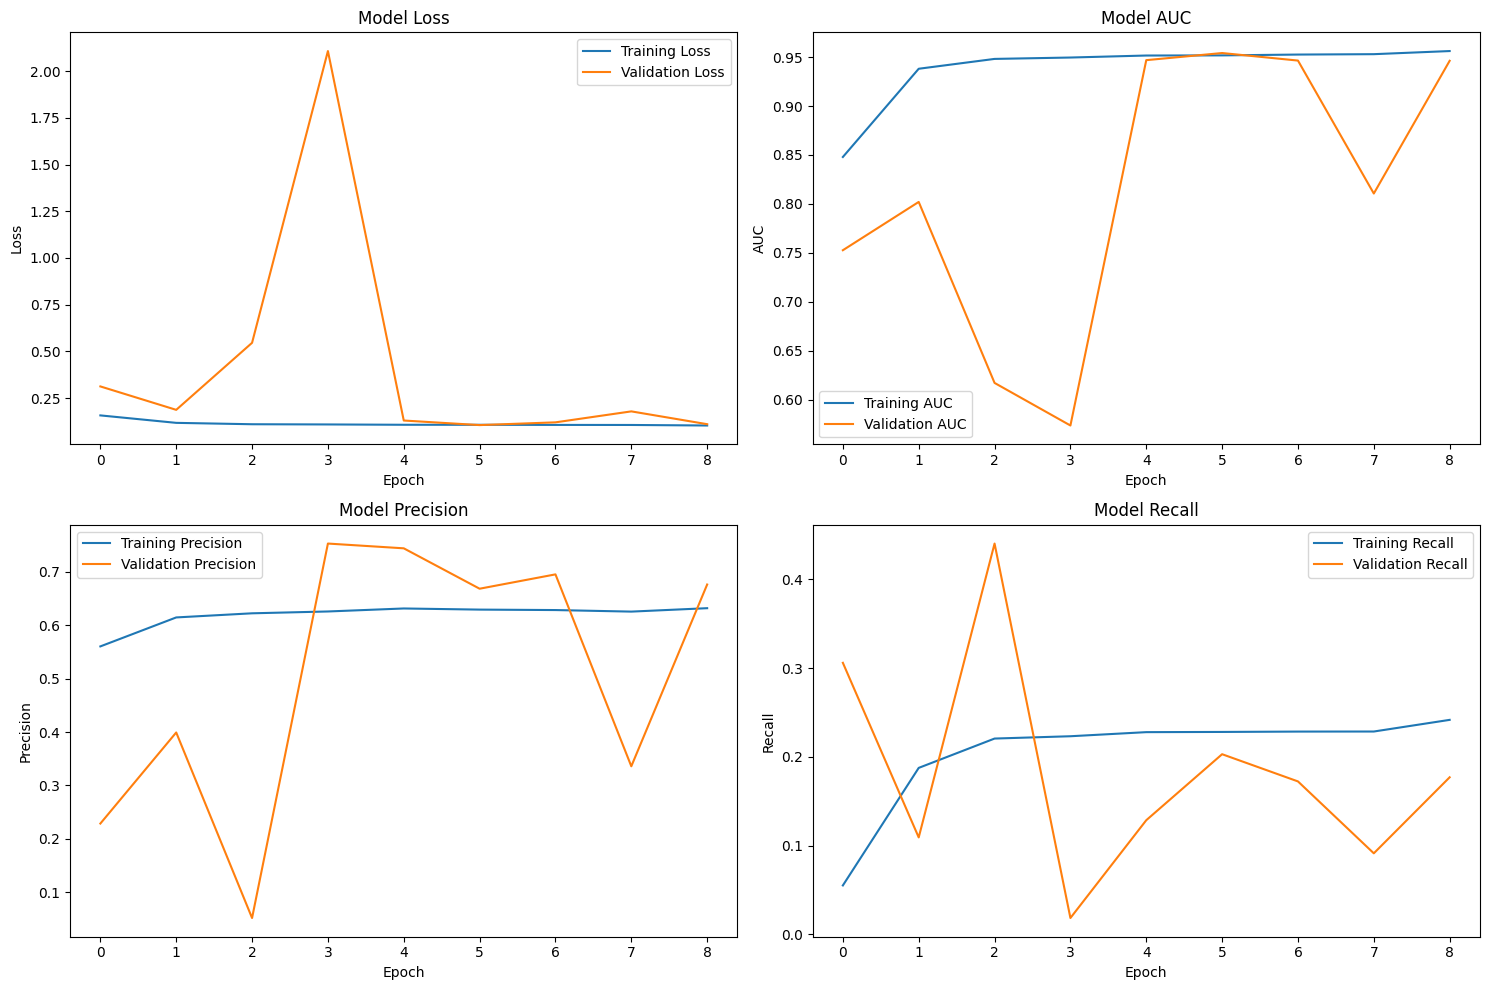

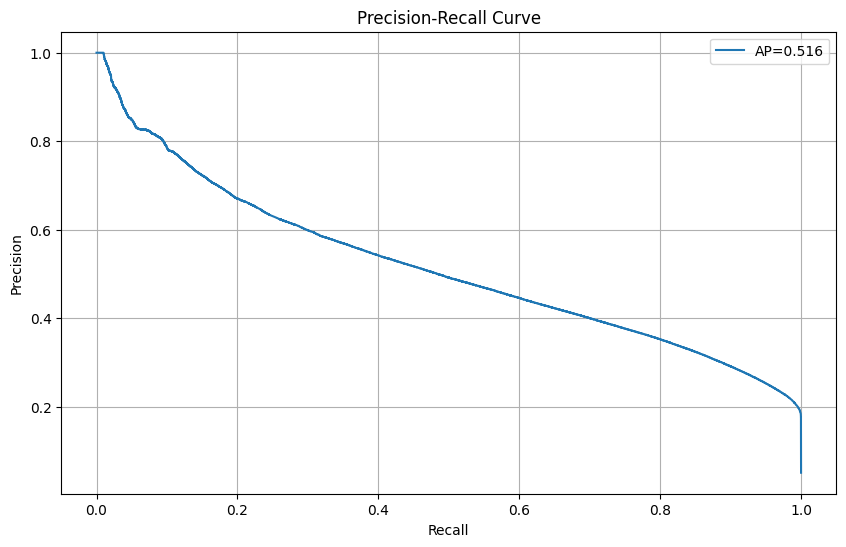

In [8]:

# 8. Evaluate the model
test_loss, test_acc, test_auc, test_precision, test_recall = din_model.evaluate(test_inputs, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# 9. Predictions & Additional Evaluation Metrics
y_pred = din_model.predict(test_inputs)
log_loss_score = log_loss(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)

print(f"Log Loss: {log_loss_score:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Average Precision: {average_precision:.4f}")

# 10. Visualize training history
plt.figure(figsize=(15, 10))

# Plot loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot AUC
plt.subplot(2, 2, 2)
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

# Plot Precision
plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Plot Recall
plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.savefig('din_training_history.png')
plt.show()

# 11. Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'AP={average_precision:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.savefig('precision_recall_curve.png')
plt.show()



In [10]:
# # 12. Feature importance using permutation importance
# from sklearn.inspection import permutation_importance

# def get_model_prediction(X):
#     """Helper function to get predictions from the model for permutation importance"""
#     inputs = prepare_model_inputs(X, cat_features, num_features)
#     return din_model.predict(inputs).flatten()

# # Create a pandas Series from features
# result = pd.Series(index=X_test.columns)

# # For each feature, compute permutation importance
# for col in X_test.columns:
#     # Create a copy of the data
#     X_test_permuted = X_test.copy()
#     # Shuffle the feature
#     X_test_permuted[col] = np.random.permutation(X_test_permuted[col].values)
#     # Get predictions
#     y_pred_permuted = get_model_prediction(X_test_permuted)
#     # Compute AUC with permuted feature
#     auc_permuted = roc_auc_score(y_test, y_pred_permuted)
#     # Compute importance as the difference in AUC
#     result[col] = roc_auc - auc_permuted

# # Sort features by importance
# importance = result.sort_values(ascending=False)

# # Plot feature importance
# plt.figure(figsize=(12, 8))
# importance.plot(kind='bar')
# plt.title('Feature Importance (Permutation-based)')
# plt.tight_layout()
# plt.savefig('din_feature_importance.png')
# plt.show()

# # 13. Compare with XGBoost (optional)
# from xgboost import XGBClassifier
# from sklearn.metrics import classification_report

# # Train XGBoost model
# xgb_model = XGBClassifier(
#     n_estimators=100,
#     learning_rate=0.1,
#     max_depth=5,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     objective='binary:logistic',
#     eval_metric='auc',
#     random_state=42
# )

# xgb_model.fit(X_train, y_train)
# xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
# xgb_auc = roc_auc_score(y_test, xgb_pred_proba)

# print(f"XGBoost AUC: {xgb_auc:.4f}")
# print(f"DIN AUC: {roc_auc:.4f}")

# # 14. Save the model for future use
din_model.save('/kaggle/working/din_ctr_model.h5')

# print("DIN model training and evaluation completed!")